<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/object_detection_TFM_A3_RezaMahdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q "tf-models-official"

In [ ]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

In [ ]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.18.0


In [ ]:
!unzip -q -o 'colab_SatelliteData.zip' -d './'

# Important note!

1- The TFM has its own tfrecord generator use the following code for generating them.

2- This generator needs a coco style json annotations if you generated your own dataset you will have to generate this yourself.

In [ ]:
%%bash

TRAIN_DATA_DIR='/content/SatelliteData/test'
TRAIN_ANNOTATION_FILE_DIR='/content/SatelliteData/test/annotations.json'
OUTPUT_TFRECORD_TRAIN='./tfrecords/train'

# Need to provide
  # 1. image_dir: where images are present
  # 2. object_annotations_file: where annotations are listed in json format
  # 3. output_file_prefix: where to write output convered TFRecords files
python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${TRAIN_DATA_DIR} \
  --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
  --output_file_prefix=$OUTPUT_TFRECORD_TRAIN \
  --num_shards=1

2025-03-04 14:01:20.763590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741096880.804705    3021 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741096880.817076    3021 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0304 14:01:29.577299 132587109249024 create_coco_tf_record.py:502] writing to output path: ./tfrecords/train
I0304 14:01:29.582797 132587109249024 create_coco_tf_record.py:374] Building bounding box index.
I0304 14:01:29.583049 132587109249024 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0304 14:01:29.797957 132587109249024 tfrecord_lib.py:168] On image 0
I0304 14:01:29.858058 132587109249024 tfrecord_lib.py:180] Fini

In [ ]:
%%bash

VALID_DATA_DIR='./SatelliteData/valid'
VALID_ANNOTATION_FILE_DIR='./SatelliteData/valid/annotations.json'
OUTPUT_TFRECORD_VALID='./tfrecords/valid'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$VALID_DATA_DIR \
  --object_annotations_file=$VALID_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_VALID \
  --num_shards=1

2025-03-04 14:01:33.109377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741096893.128946    3110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741096893.134768    3110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0304 14:01:38.229022 140238129381376 create_coco_tf_record.py:502] writing to output path: ./tfrecords/valid
I0304 14:01:38.231174 140238129381376 create_coco_tf_record.py:374] Building bounding box index.
I0304 14:01:38.231385 140238129381376 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0304 14:01:38.323761 140238129381376 tfrecord_lib.py:168] On image 0
I0304 14:01:38.350828 140238129381376 tfrecord_lib.py:180] Fini

In [ ]:
%%bash

TEST_DATA_DIR='./SatelliteData/test'
TEST_ANNOTATION_FILE_DIR='./SatelliteData/test/annotations.json'
OUTPUT_TFRECORD_TEST='./tfrecords/test'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$TEST_DATA_DIR \
  --object_annotations_file=$TEST_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_TEST \
  --num_shards=1

2025-03-04 14:01:40.668566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741096900.701020    3170 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741096900.710944    3170 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0304 14:01:50.668625 134244004700160 create_coco_tf_record.py:502] writing to output path: ./tfrecords/test
I0304 14:01:50.673992 134244004700160 create_coco_tf_record.py:374] Building bounding box index.
I0304 14:01:50.674196 134244004700160 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0304 14:01:50.861289 134244004700160 tfrecord_lib.py:168] On image 0
I0304 14:01:50.934321 134244004700160 tfrecord_lib.py:180] Finis

In [ ]:
train_data_input_path = './tfrecords/train-00000-of-00001.tfrecord'
valid_data_input_path = './tfrecords/valid-00000-of-00001.tfrecord'
test_data_input_path = './tfrecords/test-00000-of-00001.tfrecord'

## run one retinanet of your choosing. Time the training and evalutation from the list below.

retinanet_resnetfpn_coco(...): COCO object detection with RetinaNet.

retinanet_spinenet_coco(...): COCO object detection with RetinaNet using SpineNet backbone.

retinanet_spinenet_mobile_coco(...): COCO object detection with mobile RetinaNet.

In [ ]:
#exp_config = exp_factory.get_exp_config('fasterrcnn_resnetfpn_coco')

exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')


In [ ]:
batch_size = 20
num_classes = 1

HEIGHT, WIDTH = 640, 640
IMG_SIZE = [HEIGHT, WIDTH, 3]


# Backbone config.
exp_config.task.annotation_file = None
exp_config.task.freeze_backbone = True

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
# exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [ ]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 400 #4000
exp_config.trainer.steps_per_loop = 10 #100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100 #100
exp_config.trainer.checkpoint_interval = 100 #100
exp_config.trainer.validation_interval = 100 #100
exp_config.trainer.validation_steps =  10 #10 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 10
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

This may be broken in Colab.


In [ ]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': None,
                'differential_privacy_config': None,
   

<IPython.core.display.Javascript object>

In [ ]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

Done


In [ ]:
model_dir='./trained_model_retinanet'

with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

## Important note!

change the following cell according to your dataset.

In [ ]:
category_index = {
    1: {
        'id': 1,
        'name': 'piscina'
    },
    2: {
        'id': 2,
        'name': 'parking'
    },
    3: {
        'id': 3,
        'name': 'rotonda'
    }
}
tf_ex_decoder = TfExampleDecoder()

In [ ]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

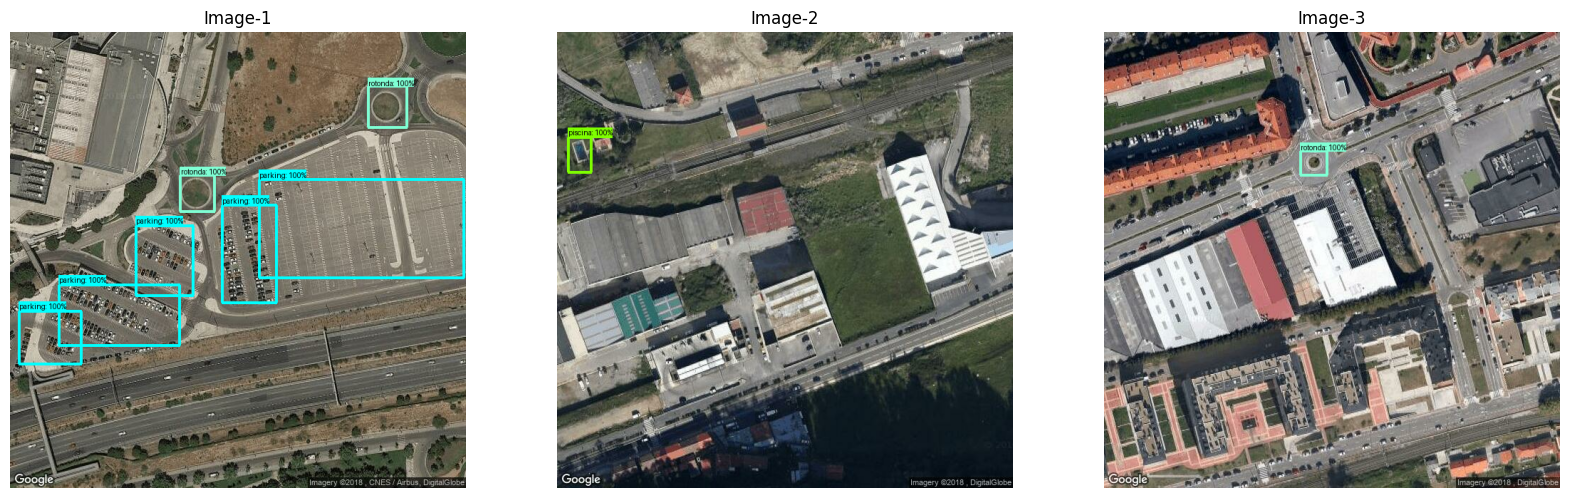

In [ ]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

# Important note!

Time the training steps and evaluation steps

In [ ]:
model_dir = "/content/model_dir_retinanet"


model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
train | step:      0 | training until step 100...
train | step:     10 | steps/sec:    0.2 | output: 
    {'box_loss': 0.037566103,
     'cls_loss': 0.7241714,
     'learning_rate': 0.099845864,
     'model_loss': 2.6024766,
     'total_loss': 3.0441597,
     'training_loss': 3.0441597}
saved checkpoint to /content/model_dir_retinanet/ckpt-10.
train | step:     20 | steps/sec:    0.6 | output: 
    {'box_loss': 0.011055367,
     'cls_loss': 1.0044196,
     'learning_rate': 0.09938442,
     'model_loss': 1.5571878,
     'total_loss': 2.0339992,
     'training_loss': 2.0339992}


In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/model_dir_retinanet'

## Save the model to your drive.


In [ ]:
export_dir = "/content/model_retinanet" # Set the export directory

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

## Evaluate your model

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

In [ ]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    './tfrecords/test-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

## Load the model

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

In [ ]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.30 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()

## Now do the same steps for :
fasterrcnn_resnetfpn_coco(...): COCO object detection with Faster R-CNN.

and make comparison of the two results regarding the training, evaluation time, and object detection scores.

In [ ]:
exp_config = exp_factory.get_exp_config('fasterrcnn_resnetfpn_coco')


In [ ]:
batch_size = 20
num_classes = 1

HEIGHT, WIDTH = 640, 640
IMG_SIZE = [HEIGHT, WIDTH, 3]


# Backbone config.
exp_config.task.annotation_file = None
exp_config.task.freeze_backbone = True

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
# exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [ ]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 400 #4000
exp_config.trainer.steps_per_loop = 100 #100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100 #100
exp_config.trainer.checkpoint_interval = 100 #100
exp_config.trainer.validation_interval = 100 #100
exp_config.trainer.validation_steps =  10 #10 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 10
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

In [ ]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

In [ ]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

In [ ]:
model_dir='./trained_model_retinanet'

with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [ ]:
category_index = {
    1: {
        'id': 1,
        'name': 'piscina'
    },
    2: {
        'id': 2,
        'name': 'parking'
    },
    3: {
        'id': 3,
        'name': 'rotonda'
    }
}
tf_ex_decoder = TfExampleDecoder()

In [ ]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

In [ ]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [ ]:
model_dir = "/content/model_dir_fasterrcnn"


model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/model_dir_fasterrcnn'

In [ ]:
export_dir = "/content/model_fasterrcnn" # Set the export directory

export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

In [ ]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    './tfrecords/test-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

In [ ]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.90 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()